In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pylidc as pl
from project_config import env_config

nodule_df_path = env_config.nodule_df_file
nodule_processed_df_path = env_config.processed_nodule_df_file
hold_out_nodule_df_path = env_config.hold_out_nodule_df_file

plots_path = "report/plots"

Most of the project will not work.
Please set the LIDC_IDRI_DIR env var in a .env file in the root directory of the project


## Distribution of annotations malignancy
NOTE: the right plot shows for the PROCESSED nodule df. That is, after it has been filtered in the processed in the `process_nodule_df.ipynb` notebook. So all the nodules that exceeds the scan border at maximum bbox size are removed!.

6859

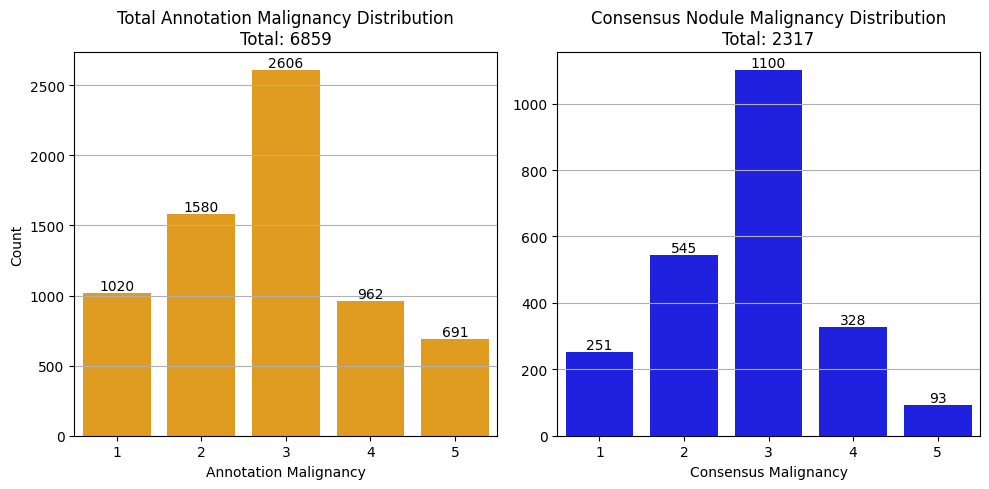

In [ ]:
annotation_malignancy_counts = [
    pl.query(pl.Annotation).filter(pl.Annotation.malignancy == 1).count(),
    pl.query(pl.Annotation).filter(pl.Annotation.malignancy == 2).count(),
    pl.query(pl.Annotation).filter(pl.Annotation.malignancy == 3).count(),
    pl.query(pl.Annotation).filter(pl.Annotation.malignancy == 4).count(),
    pl.query(pl.Annotation).filter(pl.Annotation.malignancy == 5).count(),
]

nodule_df_processed = pd.read_csv(nodule_processed_df_path)
nodule_df_holdout = pd.read_csv(hold_out_nodule_df_path)
nodule_df = pd.concat([nodule_df_processed, nodule_df_holdout], axis=0)

consensus_malignancy = nodule_df["malignancy_consensus"].value_counts().sort_index()

def plot_bar(x, y, xlabel, title, color, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    sns.barplot(x=x, y=y, color=color, ax=ax)
    for i, count in enumerate(y):
        ax.text(i, count, count, ha='center', va='bottom')
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    ax.grid(axis='y')
    return ax

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
plot_bar([1,2,3,4,5], annotation_malignancy_counts, 'Annotation Malignancy', f'Annotation Malignancy Distribution\nTotal: {sum(annotation_malignancy_counts)}', "orange", ax=axes[0])
plot_bar([1,2,3,4,5], consensus_malignancy, 'Consensus Malignancy', f'Consensus Nodule Malignancy Distribution\nTotal: {sum(consensus_malignancy)}', "blue", ax=axes[1])
axes[0].set_ylabel('Count')
axes[1].set_ylabel('')

plt.tight_layout()
plt.savefig(f'{plots_path}/malignancy_score_distribution.png')
plt.show()

## Model Performance Trend for different context windows plot

NOTE: the metric value is select from the epoch where the loss was lowest

In [43]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

local_user = "maxvisser"

def get_results_df(experiment_ids: list[str]) -> pd.DataFrame:
    results = {}
    for e in experiment_ids:
        local_exp_path = f"/Users/{local_user}/Documents/ITU/master_thesis/hpc/jobs/{e}"
        with open(f"{local_exp_path}/run_{e}.json") as f:
            config = json.load(f)
        results[e] = config

    # get aggregated results from all folds
    dataframes = []
    for exp in experiment_ids:
        info = exp.split("_")
        context = info[0]
        dimensionality = info[1]
        all_fold_results = {
            "accuracy": [],
            "mae": [],
            "mse": [],
            "auc_filtered": [],
            "auc_ovr": [],
            "cwce": [],
        }
        for fold in results[exp]["fold_results"]:
            # Find the index with the best loss
            best_loss_idx =  np.argmin(fold["val_losses"])
            print(f"Best loss idx: {best_loss_idx} of {len(fold['val_losses'])}")

            val_auc_filtered = fold["val_AUC_filtered"][best_loss_idx]
            val_auc_ovr = fold["val_AUC_ovr"][best_loss_idx]
            val_mae = fold["val_maes"][best_loss_idx]
            val_mse = fold["val_mses"][best_loss_idx]
            val_cwce = fold["val_cwces"][best_loss_idx]
            val_accuracy = fold["val_accuracies"][best_loss_idx]

            all_fold_results["accuracy"].append(val_accuracy)
            all_fold_results["mae"].append(val_mae)
            all_fold_results["mse"].append(val_mse)
            all_fold_results["auc_filtered"].append(val_auc_filtered)
            all_fold_results["auc_ovr"].append(val_auc_ovr)
            all_fold_results["cwce"].append(val_cwce)

        agg_results = {}
        for k, v in all_fold_results.items():
            agg_results[k] = context, dimensionality, np.mean(v), np.std(v)

        results_df = pd.DataFrame.from_dict(agg_results, orient="index", columns=["context", "dim", "mean", "std"])
        dataframes.append(results_df)

    results_df = pd.concat(dataframes).reset_index().rename(columns={"index": "metric"})
    return results_df

experiments_25D = [
    "c30_25D_1911_0928",
    "c50_25D_1911_1125",
    "c70_25D_1911_1411",
]
experiments_3D = [
    "c30_3D_1711_1513",
    "c50_3D_1711_2149",
]

agg_results_25D = get_results_df(experiments_25D)
agg_results_3D = get_results_df(experiments_3D)

print("\n25D")
display(agg_results_25D)
print("3D")
display(agg_results_3D)

Best loss idx: 37 of 68
Best loss idx: 38 of 66
Best loss idx: 57 of 63
Best loss idx: 57 of 71
Best loss idx: 27 of 50
Best loss idx: 58 of 83
Best loss idx: 44 of 48
Best loss idx: 44 of 70
Best loss idx: 53 of 84
Best loss idx: 76 of 83
Best loss idx: 75 of 100
Best loss idx: 59 of 90
Best loss idx: 75 of 100
Best loss idx: 89 of 91
Best loss idx: 77 of 100
Best loss idx: 87 of 100
Best loss idx: 72 of 80
Best loss idx: 74 of 93
Best loss idx: 65 of 72
Best loss idx: 70 of 86
Best loss idx: 75 of 80
Best loss idx: 88 of 100
Best loss idx: 76 of 88
Best loss idx: 38 of 40
Best loss idx: 74 of 100

25D


,metric,context,dim,mean,std
0,accuracy,c30,25D,0.54254,0.025018
1,mae,c30,25D,0.51310,0.021759
2,mse,c30,25D,0.62646,0.024821
3,auc_filtered,c30,25D,0.91800,0.031861
4,auc_ovr,c30,25D,0.72288,0.017588
5,cwce,c30,25D,0.31650,0.054119
6,accuracy,c50,25D,0.55406,0.024561
7,mae,c50,25D,0.49902,0.024285
8,mse,c50,25D,0.61314,0.031218
9,auc_filtered,c50,25D,0.89908,0.029143


3D


,metric,context,dim,mean,std
0,accuracy,c30,3D,0.55844,0.013092
1,mae,c30,3D,0.49004,0.011452
2,mse,c30,3D,0.59302,0.030128
3,auc_filtered,c30,3D,0.92226,0.020633
4,auc_ovr,c30,3D,0.73776,0.014810
5,cwce,c30,3D,0.33968,0.024541
6,accuracy,c50,3D,0.55642,0.040146
7,mae,c50,3D,0.51222,0.068765
8,mse,c50,3D,0.65902,0.125236
9,auc_filtered,c50,3D,0.89920,0.016884


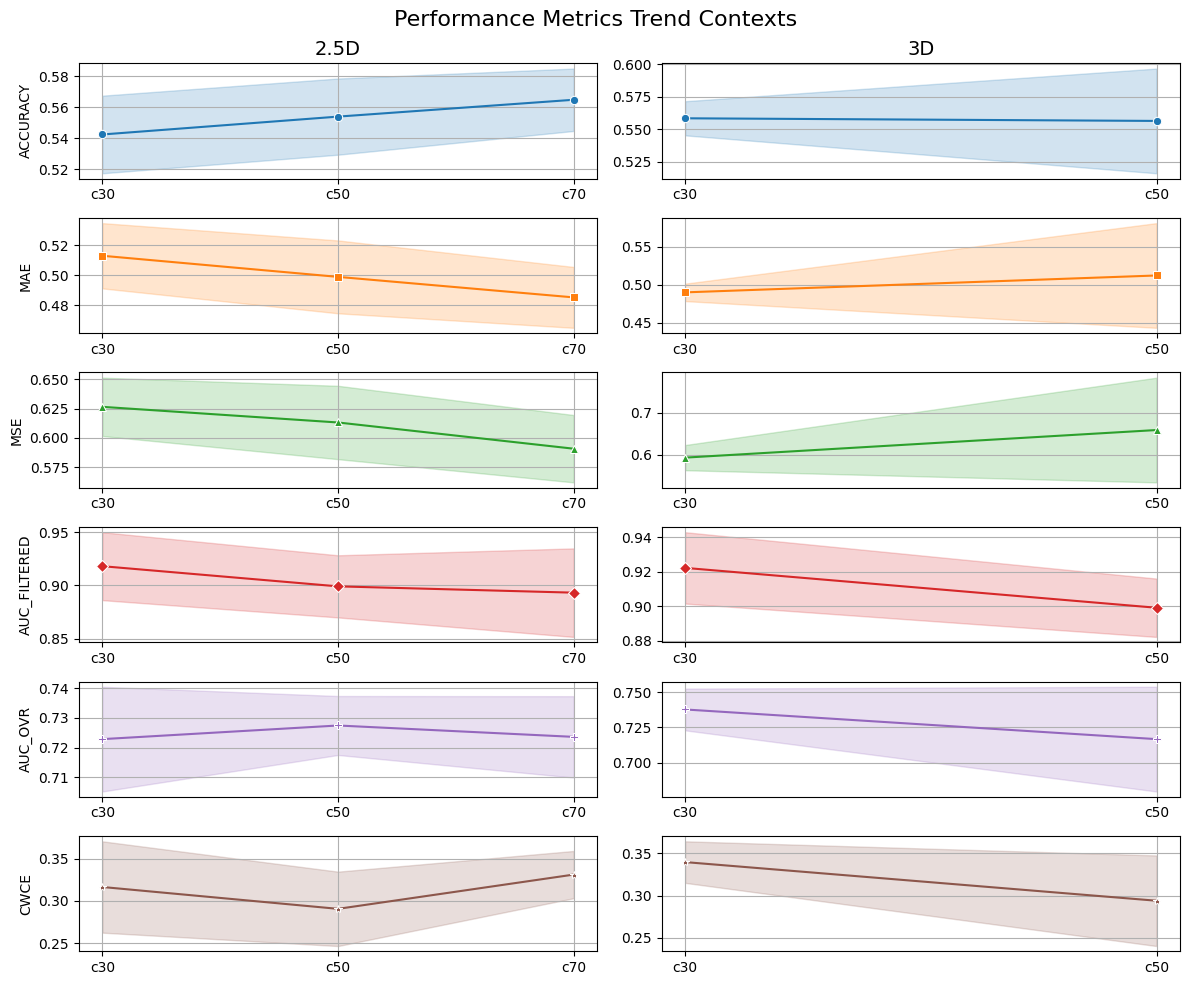

In [44]:
n_metrics = agg_results_25D["metric"].nunique()
fig, axes = plt.subplots(nrows=n_metrics, ncols=2, figsize=(12, 10))

markers = ['o', 's', '^', 'D', 'P', '*']
colors = sns.color_palette("tab10")

for i, metric in enumerate(agg_results_25D["metric"].unique()):
    metric_25D = agg_results_25D[agg_results_25D["metric"] == metric]
    metric_3D = agg_results_3D[agg_results_3D["metric"] == metric]

    # 25D
    ax = axes[i, 0]
    if i == 0:
        ax.set_title("2.5D", fontsize=14)
    sns.lineplot(x="context", y="mean", data=metric_25D, ax=ax, marker=markers[i], color=colors[i])
    ax.fill_between(
        x=metric_25D["context"],
        y1=metric_25D["mean"] - metric_25D["std"],
        y2=metric_25D["mean"] + metric_25D["std"],
        color=colors[i],
        alpha=0.2,
    )
    ax.set_ylabel(metric.upper())
    ax.set_xlabel("")
    ax.grid(True)

    # 3D
    ax = axes[i, 1]
    if i == 0:
        ax.set_title("3D", fontsize=14)
    sns.lineplot(x="context", y="mean", data=metric_3D, ax=ax, marker=markers[i], color=colors[i])
    ax.fill_between(
        metric_3D["context"],
        metric_3D["mean"] - metric_3D["std"],
        metric_3D["mean"] + metric_3D["std"],
        color=colors[i],
        alpha=0.2,
    )
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.grid(True)

plt.suptitle("Performance Metrics Trend Contexts", fontsize=16)
plt.tight_layout()
plt.show()

**NOTE**: the errorbar in the plot above is 1 whole std both above and below the line.

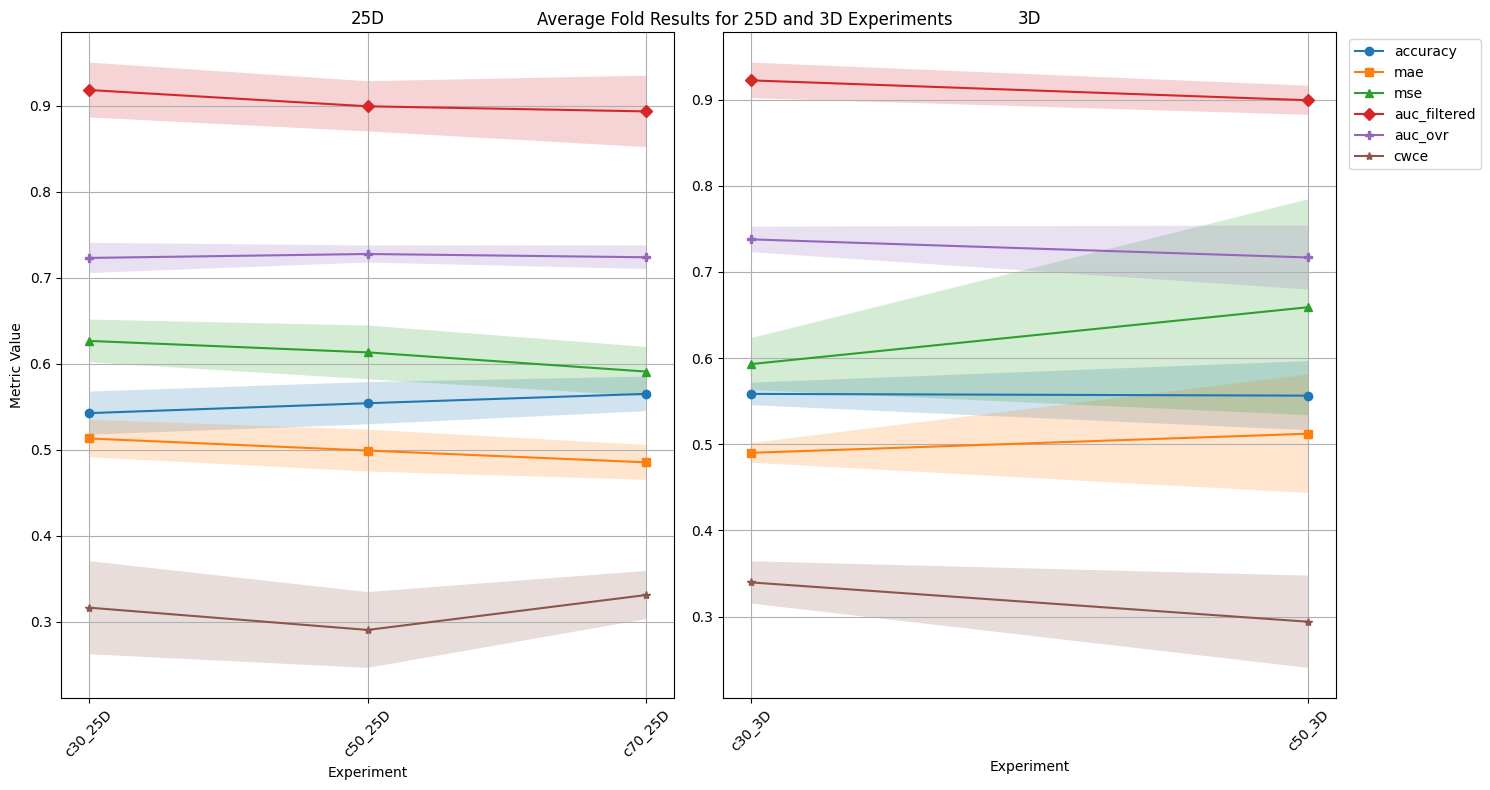

In [45]:
# Define unique markers for each line
def plot_agg_results(agg_results_df: pd.DataFrame, ax) -> plt.Figure:
    markers = ['o', 's', '^', 'D', 'P', '*']

    for metric, marker in zip(agg_results_df["metric"].unique(), markers):
    # Plot the results with different markers
        metric_data = agg_results_df.query(f"metric == '{metric}'")
        ax.plot(
            range(len(metric_data)),
            metric_data["mean"],
            label=metric,
            marker=marker,
        )
        ax.fill_between(
            range(len(metric_data)),
            metric_data["mean"] - metric_data["std"],
            metric_data["mean"] + metric_data["std"],
            alpha=0.2
        )

    # Change the x-axis labels to the context and dimensionality
    x_labels = [f"{row['context']}_{row['dim']}" for i, row in agg_results_df.query("metric == 'mae'").iterrows()]
    ax.set_xticks(ticks=range(len(x_labels)), labels=x_labels, rotation=45)
    ax.set_xlabel("Experiment")
    ax.grid(True)

    # Move the legend outside the plot
    dims = agg_results_df["dim"].unique()[0]
    ax.set_title(dims)
    return fig


fig, ax = plt.subplots(1, 2, figsize=(15, 8))
plot_agg_results(agg_results_25D, ax[0])
plot_agg_results(agg_results_3D, ax[1])
ax[0].set_ylabel("Metric Value")
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()
plt.suptitle("Average Fold Results for 25D and 3D Experiments")
plt.savefig(f"report/plots/average_fold_results.png")
plt.show()


## How noise are the annotation labels?

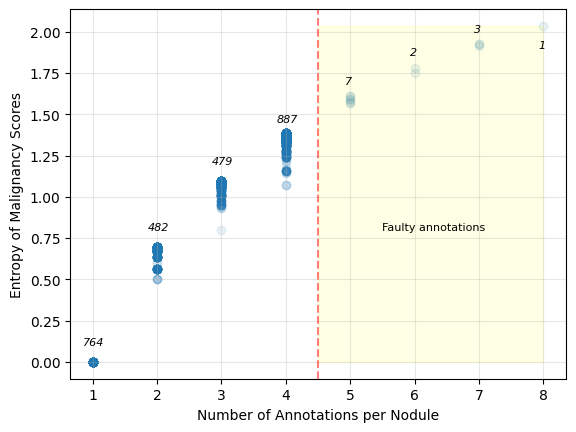

In [189]:
import ast
import numpy as np
from scipy.stats import entropy
from collections import Counter

nodule_df = pd.read_csv(nodule_df_path)
# TODO use the color to represent the number of annotations

malignancy_scores = nodule_df[
    f"malignancy_scores"
].apply(ast.literal_eval)

std = [np.std(x) for x in malignancy_scores]
ent = [entropy(x) for x in malignancy_scores]
n_annotations = [len(x) for x in malignancy_scores]
c_annotations = Counter(n_annotations)

plt.scatter(n_annotations, ent, alpha=0.1)
plt.xlabel("Number of Annotations per Nodule")
plt.ylabel("Entropy of Malignancy Scores")
plt.grid(alpha=0.3)
plt.axvline(x=4.5, color='r', linestyle='--', alpha=0.5, label="Cut-off")
plt.text(5.5, 0.8, "Faulty annotations", fontsize=8)
plt.fill_between([4.5, 8], 0, max(ent), color='yellow', alpha=0.1)

# Annotate the number of nodules with a specific number of annotations
size = 8
color = "black"
weight = "bold"
style = "italic"
plt.text(0.85, 0.10, f"{c_annotations[1]}", fontsize=size, style=style)
plt.text(1.85, 0.80, f"{c_annotations[2]}", fontsize=size, style=style)
plt.text(2.85, 1.20, f"{c_annotations[3]}", fontsize=size, style=style)
plt.text(3.85, 1.45, f"{c_annotations[4]}", fontsize=size, style=style)
plt.text(4.92, 1.68, f"{c_annotations[5]}", fontsize=size, style=style)
plt.text(5.92, 1.86, f"{c_annotations[6]}", fontsize=size, style=style)
plt.text(6.92, 2, f"{c_annotations[7]}", fontsize=size, style=style)
plt.text(7.92, 1.90, f"{c_annotations[8]}", fontsize=size, style=style)
plt.show()

# sns.jointplot(x=n_annotations, y=std)
# plt.xlabel("Number of Annotations")
# plt.ylabel("Standard Deviation")
# plt.show()

- When there is only 1 annotation, the entropy is consistently 0 because there’s no disagreement (only one label exists for each object).
- As the number of annotations increases, the entropy tends to rise. This makes sense because more annotations introduce a higher chance of disagreement between annotators.
- The general upward trend suggests that, on average, objects with more annotations tend to have higher entropy. This could mean that more annotators introduce more diversity in labeling, either because of ambiguity in the object or differences in annotator interpretation.
- you can also say, that given the substantial number of nodules with only 1 annotation, these labels are less robust since they are assessed by only a single annotator further adding to the noise in the labels.

In [ ]:
nodule_df.columns
import ast
import numpy as np
from scipy.stats import entropy
import pandas as pd

# TODO use the color to represent the number of annotations
nodule_df = pd.read_csv(nodule_df_path)
nodule_df["malignancy_scores"] = nodule_df[
    f"malignancy_scores"
].apply(ast.literal_eval)

nodule_df["malig_std"] = nodule_df["malignancy_scores"].apply(np.std)
nodule_df["malig_ent"] = nodule_df["malignancy_scores"].apply(entropy)

nodule_df.groupby("nodule_annotation_count")["malig_ent"].get_group(2)

1       0.686962
11      0.693147
21      0.693147
24      0.693147
27      0.693147
          ...   
2596    0.682908
2609    0.682908
2612    0.673012
2614    0.693147
2616    0.673012
Name: malig_ent, Length: 482, dtype: float64